In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Zaawansowane zastosowania rekurencyjnych sieci neuronowych


W tym podrozdziale opiszę trzy zaawansowane techniki pozwalające na poprawę wydajności rekurencyjnych sieci neuronowych i możliwości tworzenia przez nie uogólnień. Po przeczytaniu tego podrozdziału zdobędziesz wiedzę umożliwiającą wykorzystanie w pełni możliwości sieci rekurencyjnych zaimplementowanych w pakiecie Keras. Wszystkie trzy techniki przedstawię na przykładzie problemu przewidywania temperatury na podstawie zbioru mającego postać szeregu czasowego wartości odczytanych z czujników zamontowanych na dachu budynku. Wartości te określają temperaturę, ciśnienie i wilgotność powietrza. Użyjemy ich w celu przewidzenia temperatury za 24 godziny od ostatniej obserwacji. To dość trudne zadanie, na podstawie którego będę mógł zwrócić uwagę na wiele trudności spotykanych podczas pracy z danymi szeregu czasowego.

Opiszę następujące techniki:

* odrzucanie rekurencyjne — wbudowany algorytm odrzucania mający na celu zapobieganie przeuczeniu warstw rekurencyjnych;
* tworzenie stosów warstw rekurencyjnych — technika ta ma na celu zwiększenie mocy tworzenia reprezentacji przez sieć kosztem konieczności wykonywania bardziej złożonych obliczeń;
* dwukierunkowe warstwy rekurencyjne — warstwy przedstawiające te same informacje w sieci rekurencyjnej, ale robiące to na różne sposoby; rozwiązanie to zwiększa dokładność i rozwiązuje problemy z ginięciem informacji.

## Problem prognozowania temperatury

Dotychczas korzystaliśmy jedynie z danych sekwencyjnych w postaci tekstu (np. zbiorów danych IMDB i Agencji Reutera), ale dane o charakterze sekwencyjnym spotykane są również w wielu innych problemach niż tylko przetwarzanie języka. We wszystkich przykładach zaprezentowanych w tym podrozdziale będziemy pracować ze zbiorem danych pogodowych zarejestrowanych w stacji pogodowej instytutu Max Planck Institute for Biogeochemistry w niemieckim mieście Jena: http://www.bgc-jena.mpg.de/wetter/.

Zbiór ten zawiera 14 wielkości, takich jak temperatura powietrza, ciśnienie atmosferyczne, wilgotność i kierunek wiatru. Dane były odczytywane z czujników co 10 minut w okresie 7 lat. Oryginalny zbiór zawiera dane sięgające 2003 r., ale my ograniczmy się do przykładu danych z lat 2009 – 2016. Dane te doskonale nadają się do nauki pracy z numerycznymi danymi szeregu czasowego. Użyjemy ich do zbudowania modelu przyjmującego na wejściu dane z niedalekiej przeszłości (pomiary z kilku dni) i przewidującego temperaturę powietrza za 24 godziny.

Przyjrzyjmy się danym:

In [3]:
import os

data_dir = "D:\\Users\\Mike\\Desktop\\tes\\DeepLearning\\predict_weather\\"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Zamieńmy te 420 551 linii danych na tablicę Numpy:

In [4]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Oto przykładowy wykres zmian temperatury (wartości wyrażono w stopniach Celsjusza). Widać na nim wyraźny roczny trend okresowych zmian temperatury:

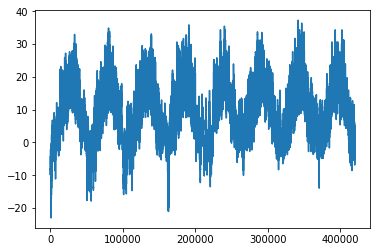

In [7]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # Temeperatura (stopnie Celsjusza)
plt.plot(range(len(temp)), temp)
plt.show()


Teraz przyjrzyjmy się wykresowi zmian temperatury w ciągu pierwszych dziesięciu dni ujętych w zbiorze. Dane były dopisywane do zbioru co 10 minut, a więc dzienny wykres zmian temperatury składa się ze 144 punktów.

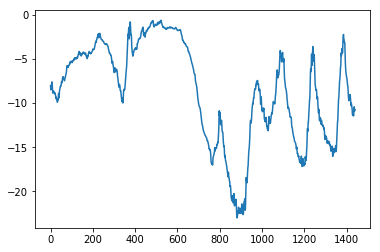

In [6]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [9]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])


Na tym wykresie widać cykl dobowy zmiany temperatur. Jest on szczególnie widoczny w przypadku 4 ostatnich dni. Zwróćmy uwagę również na to, że ten 10-dniowy okres musi pochodzić z dość zimnego zimowego miesiąca.

Przewidywanie średniej temperatury w kolejnym miesiącu na podstawie danych z kilku poprzednich miesięcy jest dość łatwe, ponieważ dane takie są powtarzalne w skali roku, ale przyglądając się danym w skali doby, można odnieść wrażenie, że zmiany temperatury są dość chaotyczne. Czy dane tego szeregu czasowego dają się przewidywać w skali doby? Sprawdźmy to.

## Przygotowywanie danych


Nasz problem ma następującą postać: na podstawie danych w formie lookback obserwacji dokonywanych co 10 minut wybieramy co steps informacje. Czy na tej podstawie możemy przewidzieć temperaturę w odstępie czasu delay? Będziemy korzystać z następujących wartości parametrów:

* `lookback = 720` - będziemy korzystać z obserwacji z 5 dni;
* `steps = 6` - będziemy korzystać z jednej obserwacji na godzinę;
* `delay = 144` - naszym celem jest określenie temperatury panującej 24 godziny później. 

Na początek musimy zrobić dwie rzeczy:

* Przetworzyć dane w celu nadania im formy, w jakiej mogą zostać skierowane do sieci neuronowej. To proste. Dane mają już charakter numeryczny, a więc nie ma potrzeby poddawania ich wektoryzacji. Niestety każda wielkość wyrażona jest w innej skali (wartości temperatury zwykle wahają się od –20 do +30, a ciśnienie atmosferyczne jest wyrażane w milibarach i przyjmuje wartości oscylujące wokół 1000. Każda z mierzonych wielkości powinna zostać poddana normalizacji w sposób niezależny. Dzięki temu będą one przyjmowały małe wartości z podobnych zakresów.
* Napisać pythonowy generator przyjmujący tablicę wartości zmiennoprzecinkowych i zwracający wsady danych z niedalekiej przeszłości (z okresu właściwego punktowi, który chcemy przewidywać). Próbki znajdujące się w zbiorze charakteryzują się dużą redundancją (próbka N i próbka N+1 przyjmują praktycznie takie same wartości). W związku z tym bez sensu jest jawnie alokować każdą próbkę. Próbki będziemy generować na bieżąco korzystając z oryginalnych danych.

Dane przygotujemy, obliczając średnią każdego szeregu i wykonując operację dzielenia przez odchylenie standardowe. Pierwszych 200 000 obserwacji użyjemy w charakterze treningowego zbioru danych. W związku z tym średnią i odchylenie standardowe należy obliczać tylko na tej części całego zbioru danych:

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Nasz generator danych zwraca krotki (samples, targets), w których obiekt samples jest wsadem danych wejściowych, a obiekt targets jest tablicą docelowych temperatur. Generator przyjmuje następujące argumenty:

* `data` — oryginalna tablica danych zmiennoprzecinkowych, które zostały znormalizowane przez kod przedstawiony w listingu 6.32;
* `lookback` — liczba kroków czasu, do których powinny sięgać dane wejściowe;
* `delay` — liczba kroków czasu określających przyszłą temperaturę;
* `min_index` i `max_index` — indeksy tablicy data określające kroki, których próbki należy odczytać. Rozwiązanie to przydaje się w celu utworzenia zbioru walidacyjnego i zbioru testowego;
* `shuffle` — określa to czy próbki mają być losowane, czy pobierane w kolejności chronologicznej;
* `batch_size` — liczba próbek wchodzących w skład wsadu;
* `step` — przedział czasu określający częstotliwość próbkowania danych. Parametrowi temu przypisujemy wartość 6, aby dysponować próbką danych odczytanych co godzinę.

In [9]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Skorzystajmy z abstrakcyjnej funkcji generator w celu utworzenia instancji trzech generatorów: potrzebujemy jednego generatora do procesu trenowania, jednego do procesu walidacji i jednego do procesu testowania. Każdy z nich będzie przetwarzał różne segmenty początkowego zbioru danych: generator treningowy przetwarza 200 000 pierwszych obserwacji, generator walidacyjny — 100 000 kolejnych obserwacji, a generator testowy — pozostałe obserwacje.

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Liczba kroków pobierania danych z obiektu val_gen 
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (300000 - 200001 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen, 
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Punkt odniesienia w postaci zdrowego rozsądku


Zanim zaczniemy przewidywać temperaturę za pomocą czarnych skrzynek — modeli uczenia głębokiego — spróbujmy to zrobić za pomocą zdrowego rozsądku. W ten sposób uzyskamy punkt odniesienia służący do oceny skuteczności pracy modelu uczenia maszynowego. Zdrowy rozsądek jest dobrym punktem odniesienia w pracy nad nowymi problemami, na które nie mamy (jeszcze) rozwiązania. Klasycznym przykładem takiej sytuacji jest nierówna klasyfikacja. Jeżeli nasz zbiór danych zawiera 90% obserwacji należących do klasy A i tylko 10% obserwacji należących do klasy B, to zgodnie ze zdrowym rozsądkiem moglibyśmy utworzyć klasyfikator przypisujący etykietę A do wszystkich nowych obserwacji. Klasyfikator taki uzyskałby skuteczność na poziomie 90%, a więc wszystkie techniki uczenia powinny uzyskać skuteczność większą niż 90%, aby można było uznać je za przydatne. Czasami utworzone w ten sposób klasyfikatory są naprawdę trudne do pokonania.

W analizowanym przykładzie możemy przyjąć bezpieczne założenie o ciągłości temperatur (jutrzejsza temperatura będzie prawdopodobnie zbliżona do dzisiejszej temperatury), a także istnienie dobowych cyklów wahań temperatury. Dlatego zdroworozsądkowym rozwiązaniem byłoby przewidywanie tego, że temperatura za 24 godziny zawsze będzie równa bieżącej temperaturze. Sprawdźmy poprawność tego założenia za pomocą metryki średniej bezwzględnej wartości błędu:

In [ ]:
np.mean(np.abs(preds - targets))

Oto pętla ewaluacyjna:

In [10]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.289735972991


Uzyskamy wartość równą 0,29. Wartości temperatury zostały znormalizowane tak, aby przyjęły wartość środkową równą 0 i odchylenie standardowe równe 1; otrzymany wynik wcale nie jest łatwo zinterpretować. Uzyskana przez nas średnia bezwzględna wartość błędu odpowiada temperaturze  2,57°C (0,29 x temperature_std = 2,57). To dość duża średnia wartość błędu. Teraz postaramy się skorzystać z naszej wiedzy na temat uczenia głębokiego i uzyskać lepszy wynik.

## Podstawowe rozwiązanie problemu przy użyciu techniki uczenia maszynowego

Podobnie jak w przypadku opracowania prostej logicznej metody będącej punktem odniesienia, możemy spróbować rozwiązać problem za pomocą prostych modeli uczenia maszynowego (np. przy użyciu małych, gęsto połączonych sieci). Zróbmy to, zanim zajmiemy się bardziej skomplikowanymi modelami takimi jak rekurencyjne sieci neuronowe. To najlepszy sposób, by upewnić się, że stosowanie bardziej złożonych modeli ma sens i przynosi realne korzyści.

Oto kod w pełni połączonego modelu, który na początku spłaszcza dane, a następnie przepuszcza je przez dwie warstwy Dense. W warstwie Dense nie zastosowano funkcji aktywacji, co jest rozwiązaniem typowym w przypadku problemów regresji. W roli funkcji straty będziemy ponownie korzystać ze średniego błędu bezwzględnego. Ewaluację przeprowadzamy za pomocą tych samych danych i tej samej metryki co w przypadku opisanego wcześniej rozwiązania pełniącego funkcję naszego punktu odniesienia, a więc będziemy mogli porównać uzyskane wyniki w sposób bezpośredni.

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 10s - loss: 1.5009 - val_loss: 0.4131
Epoch 2/20
500/500 [==============================] - 10s - loss: 0.4272 - val_loss: 0.2994
Epoch 3/20
500/500 [==============================] - 9s - loss: 0.2837 - val_loss: 0.3115
Epoch 4/20
500/500 [==============================] - 9s - loss: 0.2629 - val_loss: 0.3213
Epoch 5/20
500/500 [==============================] - 9s - loss: 0.2486 - val_loss: 0.3156
Epoch 6/20
500/500 [==============================] - 9s - loss: 0.2405 - val_loss: 0.3144
Epoch 7/20
500/500 [==============================] - 9s - loss: 0.2351 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 9s - loss: 0.2289 - val_loss: 0.3151
Epoch 9/20
500/500 [==============================] - 9s - loss: 0.2248 - val_loss: 0.3238
Epoch 10/20
500/500 [==============================] - 9s - loss: 0.2215 - val_loss: 0.3442
Epoch 11/20
500/500 [==============================] - 9s - loss: 0.2161 - val_loss: 0.

Wyświetlmy wykresy straty w procesach trenowania i walidacji:

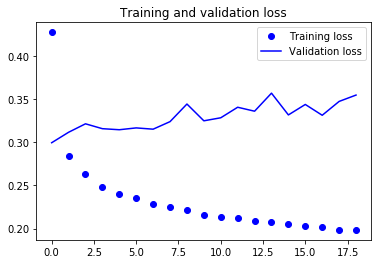

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Tylko niektóre wartości straty walidacji są zbliżone do wyniku uzyskanego metodą będącą punktem odniesienia (wyniku uzyskanego bez uczenia maszynowego). Przykład ten ma na celu pokazanie tego, że warto wyznaczyć sobie punkt odniesienia, i tego, że przekroczenie go przy użyciu modelu wcale nie jest takie łatwe. Opracowując logiczne rozwiązanie problemu, w przeciwieństwie do modelu, mieliśmy dostęp do cennych informacji.

Czy istnieje prosty model umiejący połączyć dane z wartościami docelowymi? Dlaczego opracowany przez nas model nie potrafi tego zrobić? Wynika to z tego, że nasze proste rozwiązanie nie szuka odpowiedzi na to pytanie. Przestrzeń, w której modele poszukują rozwiązania (przestrzeń hipotez), jest przestrzenią wszystkich możliwych dwuwarstwowych sieci o zdefiniowanej przez nas konfiguracji. Te sieci są już same w sobie dość skomplikowane. Jeżeli rozwiązania szuka się w przestrzeni składającej się ze skomplikowanych modeli, to proste, dobrze sprawdzające się rozwiązania bazowe mogą być nie do wytrenowania pomimo tego, że — technicznie rzecz biorąc — należą do przestrzeni hipotez. To ważne ograniczenie uczenia maszynowego: jeżeli kod algorytmu nie zostanie napisany pod kątem szukania określonego typu prostego modelu, to może się okazać, że podczas trenowania nie da się znaleźć prostego rozwiązania prostego problemu.

## Punkt odniesienia w postaci pierwszego modelu rekurencyjnego


Pierwsza w pełni połączona sieć nie sprawdziła się dobrze, ale to wcale nie oznacza, że uczenie maszynowe nie jest w stanie rozwiązać tego problemu. Sieć ta najpierw spłaszczała dane szeregów czasowych, co powodowało usunięcie informacji o czasie z danych wejściowych. Spróbujmy przyjrzeć się danym bez ich modyfikowania: przeanalizujmy je jako sekwencję, w której znaczenie ma zarówno przypadkowość, jak i porządek. Wypróbujemy działanie modelu przetwarzania rekurencyjno-sekwencyjnego. Powinien on doskonale sprawdzić się podczas przetwarzania danych sekwencyjnych. Wynika to z tego, że w przeciwieństwie do pierwszego modelu korzysta on z kolejności ustawienia danych obserwacji.

Zamiast warstwy LSTM tym razem użyjemy warstwy GRU opracowanej w 2014 r. przez zespół, któremu przewodził Junyoung Chung . Warstwy GRU (jednostki rekurencyjne ograniczone bramkami) działają na tej samej zasadzie co warstwy LSTM, ale wymagają przeprowadzenia mniej kosztownych obliczeń, co z kolei może powodować generowanie gorszych reprezentacji od warstw LSTM. Kompromis między złożonością obliczeń a siłą tworzenia reprezentacji jest standardowym problemem uczenia maszynowego.

In [25]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 169s - loss: 0.3216 - val_loss: 0.2738
Epoch 2/20
500/500 [==============================] - 168s - loss: 0.2846 - val_loss: 0.2654
Epoch 3/20
500/500 [==============================] - 168s - loss: 0.2772 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 168s - loss: 0.2707 - val_loss: 0.2663
Epoch 5/20
500/500 [==============================] - 168s - loss: 0.2643 - val_loss: 0.2680
Epoch 6/20
500/500 [==============================] - 169s - loss: 0.2584 - val_loss: 0.2644
Epoch 7/20
500/500 [==============================] - 168s - loss: 0.2553 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 168s - loss: 0.2508 - val_loss: 0.2672
Epoch 9/20
500/500 [==============================] - 165s - loss: 0.2455 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 164s - loss: 0.2423 - val_loss: 0.2801
Epoch 11/20
500/500 [==============================] - 164s - loss: 0

Czas przedstawić wyniki na wykresie:

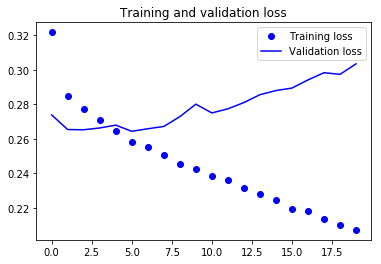

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Teraz uzyskaliśmy o wiele lepsze parametry! Znacząco pokonaliśmy zdefiniowany wcześniej klasyfikator logiczny będący naszym punktem odniesienia. Udowodniliśmy sensowność korzystania z uczenia maszynowego, a także wyższość w tego typu zadaniach sieci rekurencyjnych nad gęstymi sieciami spłaszczającymi sekwencje.

Uzyskaliśmy średnią bezwzględna wartość błędu na poziomie ~0,265 (zanim model zaczął ulegać znacznemu przeuczeniu), co odpowiada średniej pomyłce o 2,35°C. To wyraźna poprawa względem uzyskanej wcześniej wartości 2,57°C, ale wciąż możemy uzyskać o wiele lepszy wynik.

## Stosowanie rekurencyjnego porzucania w celu zmniejszenia nadmiernego dopasowania


Na wykresie trenowania i walidacji wyraźnie widać, że model ulega nadmiernemu dopasowaniu: po kilku epokach algorytmu straty trenowania i walidacji zaczynają wyraźnie się rozbiegać. Znasz już technikę służącą do zapobiegania temu zjawisku: odrzucanie (wyzerowywanie losowych jednostek wejściowych warstwy w celu zmniejszenia liczby skorelowanych wartości przekazywanych do trenowanego modelu). Zaimplementowanie tego rozwiązania w sieci rekurencyjnej nie jest prostym zadaniem. Wiadomo, że zastosowanie mechanizmu odrzucania przed warstwą rekurencyjną bardziej od usprawniania regularyzacji utrudnia proces uczenia. W 2015 r. Yarin Gal w swojej pracy doktorskiej dotyczącej bayesowskiego uczenia głębokiego  opracował właściwy sposób stosowania techniki odrzucania w kontekście rekurencyjnej sieci neuronowej: ta sama maska odrzucania (mechanizm odrzucania tych samych jednostek) powinna być stosowana podczas przetwarzanych danych każdego kroku czasu. Nie należy losować odrzucanych jednostek przed przetworzeniem danych kolejnego kroku. Ponadto w celu uregulowania reprezentacji tworzonych przez rekurencyjne bramki warstw GRU i LSTM należy stosować tymczasowo stałą maskę odrzucania, która powinna wpływać na pracę wewnętrznych rekurencyjnych aktywacji warstwy (jest to tzw. rekurencyjna maska odrzucania). Używanie tej samej maski odrzucania podczas przetwarzania danych każdego kroku czasu pozwala sieci na właściwe rozłożenie błędu uczenia w czasie. Tymczasowo losowa maska odrzucania zakłóciłaby ten sygnał błędu i byłaby szkodliwa z punktu widzenia procesu uczenia.

Yarin Gal podczas swoich badań korzystał z pakietu Keras i pomógł wbudować opracowane przez siebie rozwiązania bezpośrednio do warstw rekurencyjnych tego pakietu. Każda rekurencyjna warstwa pakietu Keras ma dwa argumenty związane z mechanizmem odrzucania: dropout (wartość zmiennoprzecinkowa określająca współczynnik odrzucania jednostek wejściowych warstwy) i recurrent_dropout (wartość określająca współczynnik odrzucania jednostek rekurencyjnych). Dodajmy mechanizm odrzucania i rekurencyjny mechanizm odrzucania do warstwy GRU i sprawdźmy, jak wpłynie to na przeuczenie modelu. Osiągnięcie punktu zbieżności przez sieć poddaną regularyzacji z odrzucaniem zawsze trwa dłużej, a więc będziemy trenować naszą sieć przez dwa razy większą liczbę epok.

In [28]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 171s - loss: 0.3526 - val_loss: 0.2740
Epoch 2/40
500/500 [==============================] - 170s - loss: 0.3138 - val_loss: 0.2742
Epoch 3/40
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 170s - loss: 0.3033 - val_loss: 0.2694
Epoch 5/40
500/500 [==============================] - 170s - loss: 0.3006 - val_loss: 0.2695
Epoch 6/40
500/500 [==============================] - 170s - loss: 0.2990 - val_loss: 0.2709
Epoch 7/40
500/500 [==============================] - 170s - loss: 0.2955 - val_loss: 0.2667
Epoch 8/40
500/500 [==============================] - 170s - loss: 0.2942 - val_loss: 0.2671
Epoch 9/40
500/500 [==============================] - 171s - loss: 0.2940 - val_loss: 0.2649
Epoch 10/40
500/500 [==============================] - 170s - loss: 0.2923 - val_loss: 0.2673
Epoch 11/40
500/500 [==============================] - 170s - loss: 0

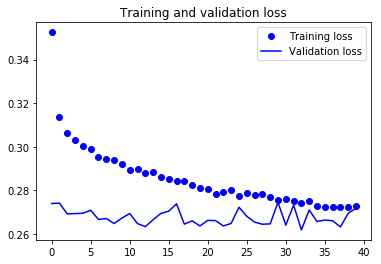

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Świetnie! Podczas pierwszych 30 epok pracy algorytmu nie dochodzi do nadmiernego dopasowania. Pomimo tego, że wyniki ewaluacji są bardziej stabilne, najlepsze uzyskane przez nas wyniki są o wiele niższe od tych, które uzyskaliśmy wcześniej.

## Tworzenie stosów warstw rekurencyjnych

Model nie ulega nadmiernemu dopasowaniu, ale doszliśmy do wydajnościowego wąskiego gardła i powinniśmy pomyśleć o zwiększeniu pojemności sieci. Przypomnij sobie opis uniwersalnego przepływu roboczego uczenia maszynowego: ogólnie rzecz biorąc, warto zwiększać pojemność sieci aż do momentu, w którym nadmierne dopasowanie stanie się główną przeszkodą (przy założeniu, że wykonywane są podstawowe czynności mające zapobiec nadmiernemu dopasowaniu, takie jak odrzucanie). Jeżeli nie osiągamy nadmiernego dopasowania, to najprawdopodobniej możemy uzyskać lepszy model).

Pojemność sieci jest zwykle zwiększana poprzez zwiększanie liczby jednostek w warstwach lub dodawanie kolejnych warstw. Tworzenie rekurencyjnych stosów warstw jest klasycznym sposobem budowania mocniejszych sieci rekurencyjnych: obecnie algorytm usługi Tłumacz Google jest oparty na stosie siedmiu warstw LSTM (to ogromna sieć).

W celu utworzenia stosu rekurencyjnych warstw w pakiecie Keras należy zadbać o to, aby wszystkie pośrednie warstwy zwracały pełne sekwencje wyjściowe (trójwymiarowe tensory), a nie tylko obiekty wyjściowe wygenerowane podczas przetwarzania ostatniej obserwacji. W tym celu należy przypisać wartość True do parametru return_sequence:

In [36]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 346s - loss: 0.3341 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 344s - loss: 0.3125 - val_loss: 0.2754
Epoch 3/40
500/500 [==============================] - 344s - loss: 0.3045 - val_loss: 0.2696
Epoch 4/40
500/500 [==============================] - 344s - loss: 0.3018 - val_loss: 0.2747
Epoch 5/40
500/500 [==============================] - 344s - loss: 0.2957 - val_loss: 0.2690
Epoch 6/40
500/500 [==============================] - 344s - loss: 0.2923 - val_loss: 0.2692
Epoch 7/40
500/500 [==============================] - 344s - loss: 0.2907 - val_loss: 0.2673
Epoch 8/40
500/500 [==============================] - 343s - loss: 0.2879 - val_loss: 0.2690
Epoch 9/40
500/500 [==============================] - 343s - loss: 0.2866 - val_loss: 0.2743
Epoch 10/40
500/500 [==============================] - 344s - loss: 0.2833 - val_loss: 0.2669
Epoch 11/40
500/500 [==============================] - 344s - loss: 0

Czas przedstawić wyniki na wykresie:

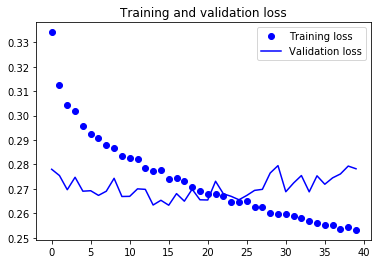

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

Z wykresu wynika, że dodanie warstwy poprawia nieco pracę modelu, ale nie jest to znaczna poprawa. Można z tego wyciągnąć dwa wnioski:

* Nie dochodzi do zbyt dużego nadmiernego dopasowania, a więc można bezpiecznie zwiększyć rozmiar warstw w celu poprawy straty walidacji. Oczywiście wiąże się to ze zwiększonym kosztem obliczeniowym.
* Dodanie warstwy nie spowodowało znacznej poprawy, a więc dalsze zwiększanie pojemności sieci może prowadzić do coraz mniej zauważalnej poprawy parametrów pracy modelu.

## Korzystanie z dwukierunkowych rekurencyjnych sieci neuronowych


Ostatnim rozwiązaniem, które chciałbym wprowadzić w tym podrozdziale, są dwukierunkowe rekurencyjne sieci neuronowe. Są to popularne wersje sieci rekurencyjnych, które w przypadku niektórych zadań charakteryzują się bardzo dobrą wydajnością. Stosuje się je często w przetwarzaniu języka naturalnego. Można określić je mianem uniwersalnego wytrychu sprawdzającego się podczas pracy nad problemami związanymi z przetwarzaniem języka naturalnego.

Rekurencyjne sieci neuronowe przetwarzają zależności wynikające z kolejności lub upływu czasu — przetwarzają one sekwencje w sposób uporządkowany. Zmiana kolejności obserwacji lub jej odwrócenie może całkowicie zmienić reprezentacje tworzone przez tego typu sieci. To właśnie z tego powodu sieci te sprawdzają się dobrze podczas rozwiązywania problemów, w których kolejność ma znaczenie (przykładem takiego problemu jest prognozowanie temperatury). Dwukierunkowe rekurencyjne sieci neuronowe korzystają z tej własności sieci rekurencyjnych. Składają się one z dwóch standardowych sieci rekurencyjnych (np. warstw GRU lub LSTM). Każda z tych sieci składowych przetwarza sekwencję wejściową w innym kierunku (chronologicznym lub przeciwnym do chronologicznego). Utworzone przez nie reprezentacje są następnie łączone. Dwukierunkowa sieć rekurencyjna, przetwarzając sekwencję w obu kierunkach, może wyłapać zależności, które nie są dostrzegane przez jednokierunkową sieć rekurencyjną.

Oczywiście chronologiczne przetwarzanie sekwencji przez zaprezentowane dotychczas warstwy sieci rekurencyjnych jest naszym nieświadomym wyborem (na razie nie mieliśmy okazji, aby podważyć jego sensowność). Czy sieci rekurencyjne działałyby wystarczająco dobrze, gdyby przetwarzały sekwencje wejściowe w kierunku odwrotnym do kolejności chronologicznej? Sprawdźmy to w praktyce, Wystarczy utworzyć generator, który odwraca sekwencję wejściową według wymiaru będącego osią czasu (musimy zastąpić ostatnią linię kodu następującym rozwiązaniem: yield samples[:, ::-1, :], targets). Po wytrenowaniu tej samej sieci z jedną warstwą GRU (z warstwy tej korzystaliśmy w pierwszym eksperymencie) uzyskamy następujące wyniki:

In [40]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [44]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 172s - loss: 0.4781 - val_loss: 0.4797
Epoch 2/20
500/500 [==============================] - 171s - loss: 0.4529 - val_loss: 0.4679
Epoch 3/20
500/500 [==============================] - 170s - loss: 0.4071 - val_loss: 0.4536
Epoch 4/20
500/500 [==============================] - 171s - loss: 0.3670 - val_loss: 0.4398
Epoch 5/20
500/500 [==============================] - 170s - loss: 0.3343 - val_loss: 0.4320
Epoch 6/20
500/500 [==============================] - 170s - loss: 0.3191 - val_loss: 0.4388
Epoch 7/20
500/500 [==============================] - 170s - loss: 0.3065 - val_loss: 0.4186
Epoch 8/20
500/500 [==============================] - 170s - loss: 0.2938 - val_loss: 0.4014
Epoch 9/20
500/500 [==============================] - 170s - loss: 0.2824 - val_loss: 0.4077
Epoch 10/20
500/500 [==============================] - 170s - loss: 0.2724 - val_loss: 0.4090
Epoch 11/20
500/500 [==============================] - 170s - loss: 0

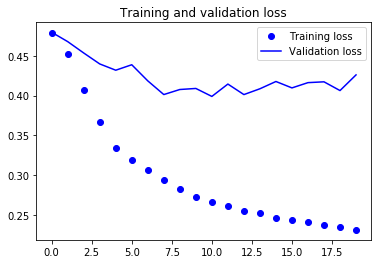

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()


Po odwróceniu kolejności sekwencji model uzyskuje gorsze parametry od opracowanego na początku punktu odniesienia, co świadczy o tym, że chronologiczne przetwarzanie danych jest ważne. Wynika to z tego, że warstwa GRU zwykle lepiej zapamiętuje niedaleką niż daleką przeszłość, a dane z niedalekiej przeszłości mają większe znaczenie przy przewidywaniu przyszłości od obserwacji z przeszłości (założenie to sprawia, że utworzony przez nas punkt odniesienia sprawdza się tak dobrze w przypadku tego problemu). W związku z tym chronologiczna wersja warstwy musi sprawdzać się lepiej od jej odwróconej wersji. Warto zauważyć, że założenie to nie jest prawdziwe w przypadku wielu innych problemów, w tym przetwarzania języka naturalnego: to, jak bardzo znaczenie danego słowa jest ważne dla zrozumienia sensu całego zdania, zwykle nie zależy od jego pozycji w zdaniu (zasada ta sprawdza się w języku angielskim). Spróbujmy zastosować tę samą sztuczkę w przykładzie warstwy LSTM przetwarzającej zbiór IMDB, przedstawionym w podrozdziale 6.2.

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Liczba słów traktowanych jako cechy.
max_features = 10000
# Ucina recenzje po tej liczbie słów należących do zbioru max_features słów najczęściej występujących w zbiorze.
maxlen = 500

# Ładowanie danych.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Odwracanie sekwencji.
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Blokowanie sekwencji.
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 111s - loss: 0.4965 - acc: 0.7648 - val_loss: 0.3593 - val_acc: 0.8570
Epoch 2/10
20000/20000 [==============================] - 107s - loss: 0.3105 - acc: 0.8810 - val_loss: 0.3329 - val_acc: 0.8648
Epoch 3/10
20000/20000 [==============================] - 105s - loss: 0.2566 - acc: 0.9057 - val_loss: 0.3863 - val_acc: 0.8770
Epoch 4/10
20000/20000 [==============================] - 106s - loss: 0.2231 - acc: 0.9195 - val_loss: 0.3471 - val_acc: 0.8556
Epoch 5/10
20000/20000 [==============================] - 105s - loss: 0.1912 - acc: 0.9314 - val_loss: 0.3346 - val_acc: 0.8694
Epoch 6/10
20000/20000 [==============================] - 105s - loss: 0.1721 - acc: 0.9379 - val_loss: 0.3621 - val_acc: 0.8520
Epoch 7/10
20000/20000 [==============================] - 105s - loss: 0.1613 - acc: 0.9427 - val_loss: 0.3438 - val_acc: 0.8694
Epoch 8/10
20000/20000 [========================

Uzyskaliśmy wydajność praktycznie taką samą jak sieć z warstwą LSTM przetwarzająca dane w kolejności chronologicznej. O dziwo, w przypadku tego tekstowego zbioru danych przetwarzanie w kolejności odwrotnej sprawdza się tak samo dobrze jak przetwarzanie w kolejności chronologicznej, co potwierdza hipotezę o tym, że kolejność słów ma znaczenie dla zrozumienia języka, ale kierunek odczytywania słów już nie. Najważniejszą rzeczą, na którą należy zwrócić uwagę, jest to, że rekurencyjna sieć trenowana na odwróconej sekwencji nauczy się innych reprezentacji od sieci, która jest trenowana na standardowej sekwencji. Postrzega ona sekwencję w sposób odwrotny — można to porównać do postrzegania świata, gdyby czas w nim płynął odwrotnie (najpierw umieralibyśmy, a pod koniec życia byśmy się rodzili). Zawsze warto korzystać z reprezentacji danych, które są inne, ale przydatne. Im bardziej się one różnią, tym lepiej — pozwalają spojrzeć na dane z innej perspektywy, a więc pozwalają zwiększyć wydajność modelu. Ta filozofia stanowi podstawę złożeń — techniki, którą opiszę w rozdziale 7.

Dwukierunkowa rekurencyjna sieć neuronowa korzysta z tego mechanizmu w celu poprawy wydajności w stosunku do rekurencyjnych sieci neuronowych przetwarzających dane tylko w kolejności chronologicznej. Sekwencje są analizowane w dwóch kierunkach, co pozwala na uzyskanie potencjalnie bogatszych reprezentacji zawierających wzorce, które mogłyby zostać przeoczone przez algorytm przetwarzający dane tylko w kolejności chronologicznej.

![bidirectional rnn](img\6_3.png)

W celu utworzenia instancji dwukierunkowej sieci rekurencyjnej należy skorzystać z warstwy Bidirectional zaimplementowanej w pakiecie Keras, która jako swój pierwszy argument przyjmuje instancję warstwy rekurencyjnej. Funkcja Bidirectional tworzy drugą oddzielną instancję tej warstwy. Jedna instancja jest używana do przetwarzania sekwencji wejściowej w kierunku chronologicznym, a druga instancja jest używana do przetwarzania odwróconej sekwencji wejściowej. Wypróbujmy działanie tego rozwiązania w celu rozwiązania problemu analizy sentymentu recenzji filmów wchodzących w skład zbioru IMDB.

In [4]:
from keras import backend as K
K.clear_session()

In [5]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 214s - loss: 0.5994 - acc: 0.6865 - val_loss: 0.4722 - val_acc: 0.8090
Epoch 2/10
20000/20000 [==============================] - 213s - loss: 0.3673 - acc: 0.8543 - val_loss: 0.3769 - val_acc: 0.8448
Epoch 3/10
20000/20000 [==============================] - 213s - loss: 0.2743 - acc: 0.8972 - val_loss: 0.3196 - val_acc: 0.8688
Epoch 4/10
20000/20000 [==============================] - 211s - loss: 0.2310 - acc: 0.9150 - val_loss: 0.2972 - val_acc: 0.8856
Epoch 5/10
20000/20000 [==============================] - 211s - loss: 0.2009 - acc: 0.9261 - val_loss: 0.4461 - val_acc: 0.8514
Epoch 6/10
20000/20000 [==============================] - 210s - loss: 0.1912 - acc: 0.9339 - val_loss: 0.3636 - val_acc: 0.8640
Epoch 7/10
20000/20000 [==============================] - 209s - loss: 0.1670 - acc: 0.9423 - val_loss: 0.3476 - val_acc: 0.8580
Epoch 8/10
20000/20000 [========================

Rozwiązanie to sprawdza się nieco lepiej od zaprezentowanego wcześniej kodu korzystającego ze standardowej warstwy LSTM — teraz uzyskaliśmy dokładność walidacyjną na poziomie ponad 89%. Model ten szybciej zaczyna ulegać przeuczeniu, co nie jest niczym dziwnym — dwukierunkowa warstwa ma dwa razy tyle parametrów, co zwykła warstwa LSTM. Po dodaniu mechanizmów zapewniających regularyzację technika dwukierunkowego przetwarzania danych sprawdziłaby się w tym zadaniu jeszcze lepiej.

Sprawdźmy działanie tej metody podczas przewidywania temperatury:

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 325s - loss: 0.3029 - val_loss: 0.2660
Epoch 2/40
500/500 [==============================] - 324s - loss: 0.2751 - val_loss: 0.2660
Epoch 3/40
500/500 [==============================] - 326s - loss: 0.2668 - val_loss: 0.2628
Epoch 4/40
500/500 [==============================] - 326s - loss: 0.2594 - val_loss: 0.2615
Epoch 5/40
500/500 [==============================] - 324s - loss: 0.2532 - val_loss: 0.2684
Epoch 6/40
500/500 [==============================] - 324s - loss: 0.2442 - val_loss: 0.2674
Epoch 7/40
500/500 [==============================] - 324s - loss: 0.2405 - val_loss: 0.2700
Epoch 8/40
500/500 [==============================] - 324s - loss: 0.2343 - val_loss: 0.2782
Epoch 9/40
500/500 [==============================] - 324s - loss: 0.2293 - val_loss: 0.2778
Epoch 10/40
500/500 [==============================] - 324s - loss: 0.2233 - val_loss: 0.2813
Epoch 11/40
500/500 [==============================] - 324s - loss: 0


Uzyskaliśmy wydajność zbliżoną do modelu ze standardową warstwą GRU. Wynika to z tego, że cała zdolność do przewidywania modelu musi pochodzić z chronologicznej połowy sieci (wcześniej udowodniliśmy, że połowa sieci przetwarzająca dane w kolejności odwrotnej zupełnie nie sprawdza się podczas pracy nad tym zadaniem, co wynika z tego, że w tym problemie bliższa przeszłość jest ważniejsza od tej dalszej).


## Kolejne rozwiązania

Wydajność modelu prognozującego pogodę można spróbować poprawić za pomocą wielu innych rozwiązań:

* Dostrajanie liczby jednostek w każdej warstwie rekurencyjnej stosu. Obecnie dobrane są dość przypadkowe liczby jednostek, a więc rozwiązanie to nie jest optymalne.
* Dobranie lepszej wartości parametru uczenia optymalizatora RMSprop.
* Zastąpienie warstw GRU warstwami LSTM.
* Próba  umieszczenia większej gęsto połączonej warstwy regresji na warstwach rekurencyjnych — umieszczenie większej warstwy Dense lub nawet umieszczenie stosu warstw Dense.
* Nie zapomnij uruchomić model, który uzyska najlepszy wynik walidacji na testowym zbiorze danych! W przeciwnym razie możesz utworzyć architektury, które będą nadmiernie dopasowane do zbioru walidacyjnego.  

Uczenie głębokie to bardziej sztuka niż nauka. Mogę przedstawić wskazówki, które sprawdzą się podczas rozwiązywania niektórych problemów, ale w przypadku pracy nad innymi problemami okażą się bezużyteczne. Każdy problem jest wyjątkowy i wymaga przyjęcia odpowiedniej strategii. Obecnie nie ma teorii, które powiedzą Ci dokładnie, co należy zrobić w celu optymalnego rozwiązania problemu. Musisz sprawdzić działanie różnych mechanizmów.


## Wnioski

Oto wnioski, które należy wynieść z tego podrozdziału:

* Zgodnie z tym, co pisałem w rozdziale 4.: podchodząc do nowego problemu, warto wyznaczyć sobie punkt odniesienia i metrykę. Jeżeli tego nie zrobisz, to nie będziesz wiedzieć, czy tworząc kolejne modele, dokonujesz realnego postępu.
* Na początek wypróbuj działanie prostych modeli, a dopiero później zaczynaj pracę nad złożonymi. Czasami zastosowanie prostego modelu sprawdza się najlepiej.
* W przypadku danych, których kolejność ma znaczenia, doskonale sprawdzają się sieci rekurencyjne. Z łatwością można dzięki nim uzyskać wyniki lepsze od modeli, które najpierw spłaszczają dane.
* W celu zastosowania techniki odrzucania podczas pracy z sieciami rekurencyjnymi należy skorzystać z odrzucania o stałym czasie i maski odrzucania rekurencyjnego. Rozwiązania te są wbudowane w warstwy rekurencyjne pakietu Keras, a więc wystarczy posłużyć się argumentami droput i recurrent_dropout.
* Stosy warstw sieci rekurencyjnych charakteryzują się większą zdolnością tworzenia reprezentacji od pojedynczej warstwy sieci rekurencyjnej. Korzystanie z nich wiąże się z dużym wzrostem skomplikowania obliczeń, a więc nie zawsze warto je stosować. Sprawdzają się one podczas pracy ze złożonymi problemami, takimi jak tłumaczenie maszynowe, ale nie zawsze warto z nich korzystać w celu rozwiązania mniejszych i prostszych problemów.
* Dwukierunkowe rekurencyjne sieci neuronowe analizują sekwencje w obu kierunkach. Warto z nich korzystać w rozwiązywaniu problemów przetwarzania języka naturalnego. Nie sprawdzają się one najlepiej w przypadku sekwencji danych, w których dane z niedalekiej przeszłości są ważniejsze od danych znajdujących się na początku sekwencji.

Uwaga. Chciałbym zwrócić uwagę na dwie ważne koncepcje, które nie zostały wyjaśnione w tym rozdziale: uwaga rekurencyjna i maskowanie sekwencji. Obie koncepcje przydają się szczególnie podczas przetwarzania języka naturalnego, ale nie przydadzą się w pracy nad problemem prognozowania temperatury. Poszukaj informacji na ich temat po skończeniu lektury tej książki.
